# Predictiva posterior: Modelos de futbol

In [1]:
# import all libraries used in this notebook
import os
import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from IPython.core.magic import register_cell_magic
import time
import arviz as az
import xarray as xr
from outils import load_config
from statistics import mean
from sklearn.preprocessing import LabelEncoder
from predictiva_posterior import ajuste_posterior_predictiva, grafica_barras_replicaciones_observados
from predictiva_posterior import grafica_media_std_replicaciones, grafica_scatter_estadisticas 
from predictiva_posterior import calcula_metricas, loglik_posterior_predictiva

# Datos

In [2]:
CURRENT = os.getcwd()
ROOT = os.path.dirname(CURRENT)

In [3]:
config_f = load_config("config.yml")

In [4]:
df_ = (
    # --------------------------------------------------- Carga de datos crudos
    pd.read_csv(
        os.path.join(ROOT, config_f["datos"]["raw"])
        ,encoding='latin1')
    # ---------------------------------------------------- Acotar datos a scope
    .query("year > 2018")
    .query("tournament == 'FIFA World Cup qualification'")
    # --------------------------------------------- Filtrar columnas de interés
    .filter(items=[
        'date'
        ,'tournament'
        ,'home_team'
        ,'away_team'
        ,'home_team_continent'
        ,'away_team_continent'
        ,'home_team_score'
        ,'away_team_score'
    ])
    # ------------------------------------ Transformación a columnas existentes
    .assign(
        date = lambda df_: pd.to_datetime(df_.date)
        ,home_team = lambda df_: pd.Categorical(df_.home_team)
        ,away_team = lambda df_: pd.Categorical(df_.away_team)
        ,home_team_continent = lambda df_: pd.Categorical(df_.home_team_continent)
        ,away_team_continent = lambda df_: pd.Categorical(df_.away_team_continent)
    )
    # --------------------------------------- Asignación de columnas computadas
    .assign(
        result = lambda df_: 
            # -1: Away win, 0: Draw, 1: Home win
            (df_.home_team_score - df_.away_team_score).apply(np.sign)
    )
)

df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 863 entries, 21128 to 23890
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 863 non-null    datetime64[ns]
 1   tournament           863 non-null    object        
 2   home_team            863 non-null    category      
 3   away_team            863 non-null    category      
 4   home_team_continent  863 non-null    category      
 5   away_team_continent  863 non-null    category      
 6   home_team_score      863 non-null    int64         
 7   away_team_score      863 non-null    int64         
 8   result               863 non-null    int64         
dtypes: category(4), datetime64[ns](1), int64(3), object(1)
memory usage: 65.3+ KB


In [5]:
encoder = LabelEncoder()
encoder.fit(pd.concat([df_['home_team'], df_['away_team']]))

df_['team1'] = encoder.transform(df_['home_team']) + 1  
df_['team2'] = encoder.transform(df_['away_team']) + 1

# Número de partidos y equipos
N = len(df_)
K = len(encoder.classes_)

data = {
  'N': N,
  'K': K,
  'team1': df_['team1'].tolist(),
  'team2': df_['team2'].tolist(),
  'y1': df_['home_team_score'].tolist(),
  'y2': df_['away_team_score'].tolist(),
}

In [6]:
modelString="""
data {
  int<lower=0> N;          // Número de partidos
  int<lower=0> K;          // Número de equipos
  int<lower=1,upper=K> team1[N];  // Índices de equipos locales
  int<lower=1,upper=K> team2[N];  // Índices de equipos visitantes
  int<lower=0> y1[N];      // Goles equipo local
  int<lower=0> y2[N];      // Goles equipo visitante
}

parameters {
  real home;
  real intercept;
  vector[K] attack_raw;
  vector[K] defence_raw;
  real<lower=0> sigma_attack;
  real<lower=0> sigma_defence;
}

transformed parameters {
  vector[K] attack = attack_raw - mean(attack_raw);
  vector[K] defence = defence_raw - mean(defence_raw);
}

model {
  vector[N] theta1;
  vector[N] theta2;

  for (n in 1:N) {
    theta1[n] = home + attack[team1[n]] - defence[team2[n]] + intercept;
    theta2[n] = attack[team2[n]] - defence[team1[n]] + intercept;
  }

  // Priors
  intercept ~ normal(0, 1);
  home ~ normal(0, 1);
  attack_raw ~ normal(0, sigma_attack);
  defence_raw ~ normal(0, sigma_defence);
  sigma_attack ~ cauchy(0, 3);
  sigma_defence ~ cauchy(0, 3);

  // Identificabilidad
  sum(attack) ~ normal(0, 0.01);
  sum(defence) ~ normal(0, 0.01);

  // Likelihood
  y1 ~ poisson_log(theta1);
  y2 ~ poisson_log(theta2);
}

generated quantities {
  int y1_sim[N];
  int y2_sim[N];
  vector[N] theta1_sim;
  vector[N] theta2_sim;

  for (n in 1:N) {
    theta1_sim[n] = home + attack[team1[n]] - defence[team2[n]] + intercept;
    theta2_sim[n] = attack[team2[n]] - defence[team1[n]] + intercept;

    y1_sim[n] = poisson_log_rng(theta1_sim[n]);
    y2_sim[n] = poisson_log_rng(theta2_sim[n]);
  }
}



"""

In [7]:
estadisticas_replicaciones_locales, muestras_aleatorias_locales, \
ajuste, estadisticas_replicaciones_visitantes, muestras_aleatorias_visitantes = \
ajuste_posterior_predictiva(
    "predicitva_posterior_estatico.stan",
    modelString, data,
    df_,
    10000, 3)

20:36:18 - cmdstanpy - INFO - compiling stan file /home/juanpalms/Desktop/MCD/Metodos analiticos/PROYECTO/futbol_bayes/modelos/predicitva_posterior_estatico.stan to exe file /home/juanpalms/Desktop/MCD/Metodos analiticos/PROYECTO/futbol_bayes/modelos/predicitva_posterior_estatico
20:36:32 - cmdstanpy - INFO - compiled model executable: /home/juanpalms/Desktop/MCD/Metodos analiticos/PROYECTO/futbol_bayes/modelos/predicitva_posterior_estatico
20:36:32 - cmdstanpy - WARNING - Stan compiler has produced 6 warnings:
20:36:32 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/tmp/tmpozm4lgvp/tmp8w99h3dg.hpp /tmp/tmpozm4lgvp/tmp8w99h3dg.stan
Warning in '/tmp/tmpozm4lgvp/tmp8w99h3dg.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 

In [12]:
config_f

{'main': {'components_repository': 'https://github.com/CAMM961001/futbol_bayes',
  'project_name': 'futbol_bayes',
  'steps': 'all'},
 'datos': {'raw': 'datos/raw/futbol.csv',
  'cat_raw': 'datos/raw/_cat_futbol.info'},
 'modelos': {'dir': 'modelos', 'template': 'modelos/__template__.stan'},
 'resultados': {'previas_dir': 'previas', 'posteriores_dir': 'posteriores'},
 'models_directory': 'modelos',
 'visuals': {'colors': {'verde': '#acce91',
   'amarillo': '#ffc125',
   'rojo': 'cb4154',
   'azul': '#07d8de'}}}

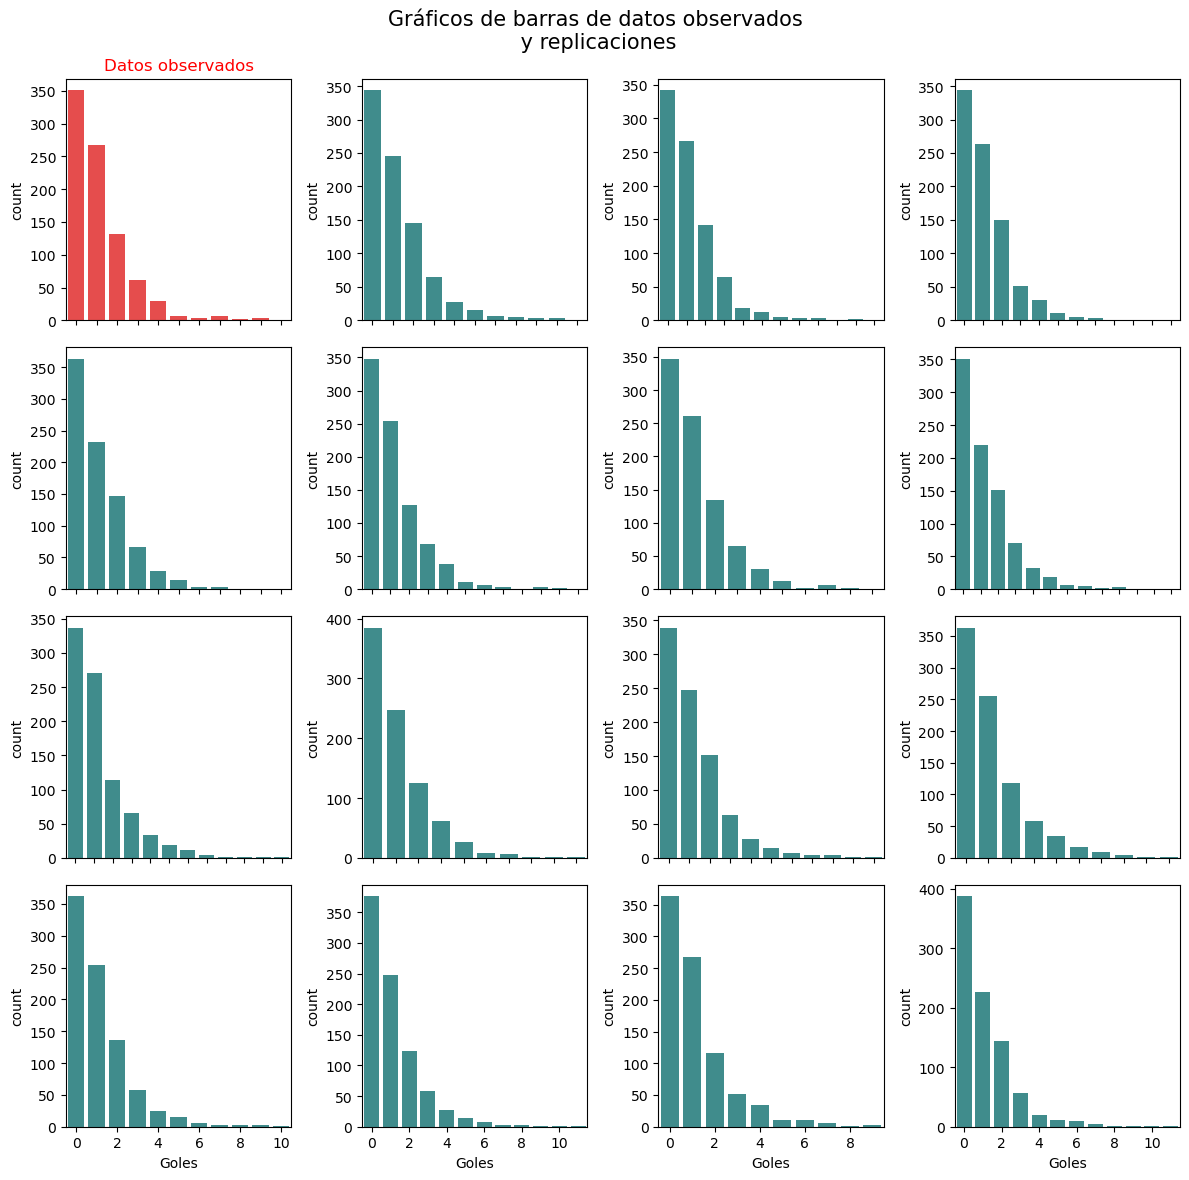

In [21]:
grafica_barras_replicaciones_observados(muestras_aleatorias_visitantes)
plt.savefig(os.path.join(ROOT, "resultados","posteriores",
                         "goles_observados_vs_replicaciones: VISITANTES"))

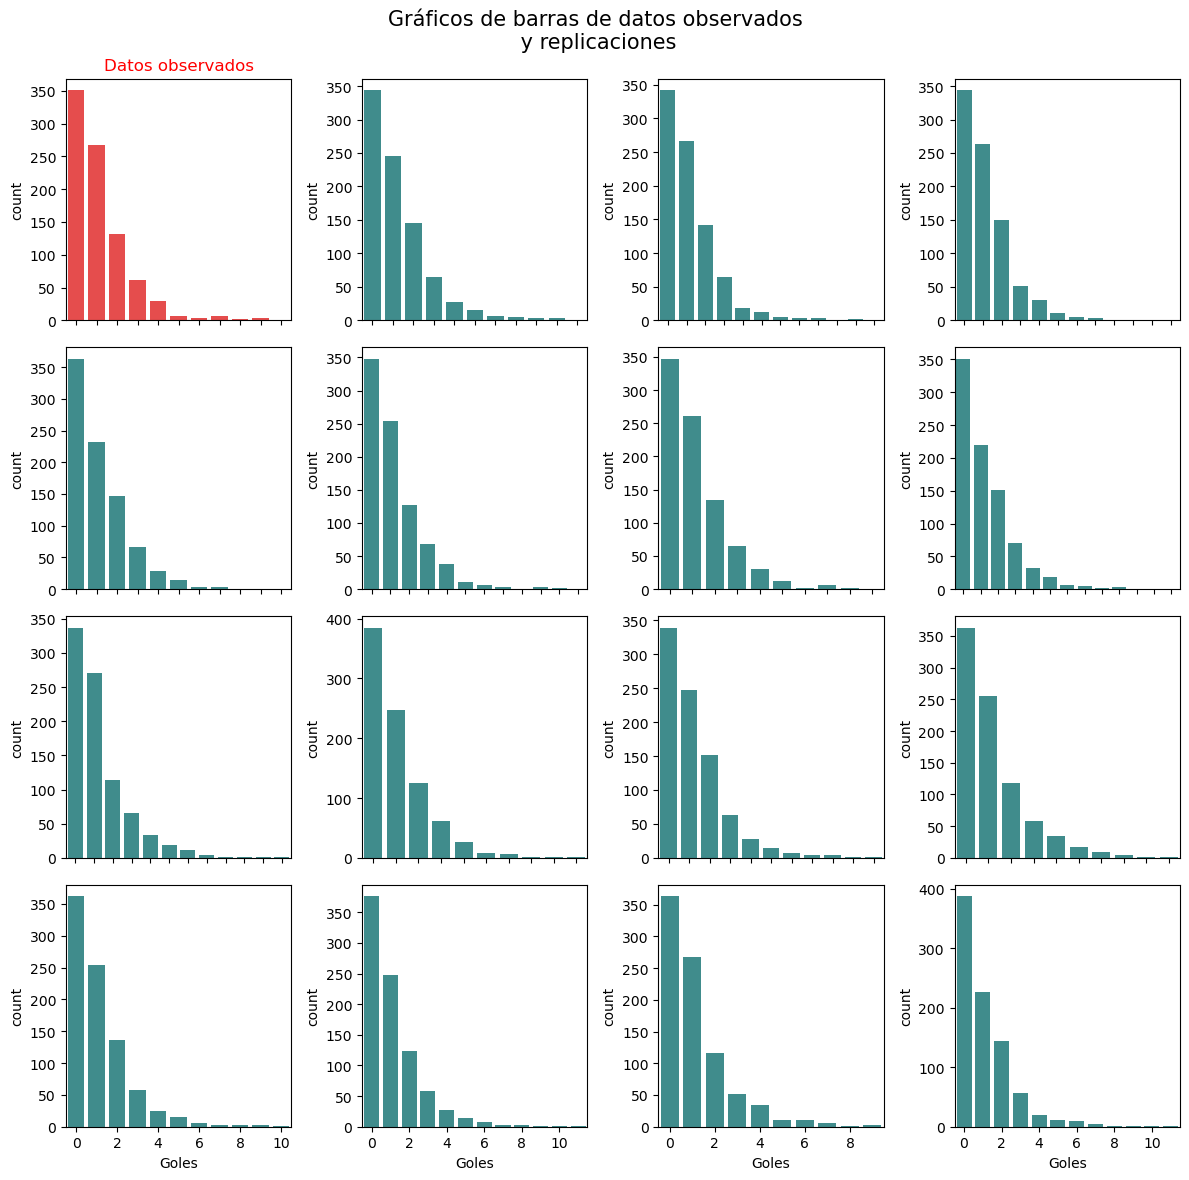

In [21]:
grafica_barras_replicaciones_observados(muestras_aleatorias_visitantes)
plt.savefig(os.path.join(ROOT, "resultados","posteriores",
                         "goles_observados_vs_replicaciones: VISITANTES"))

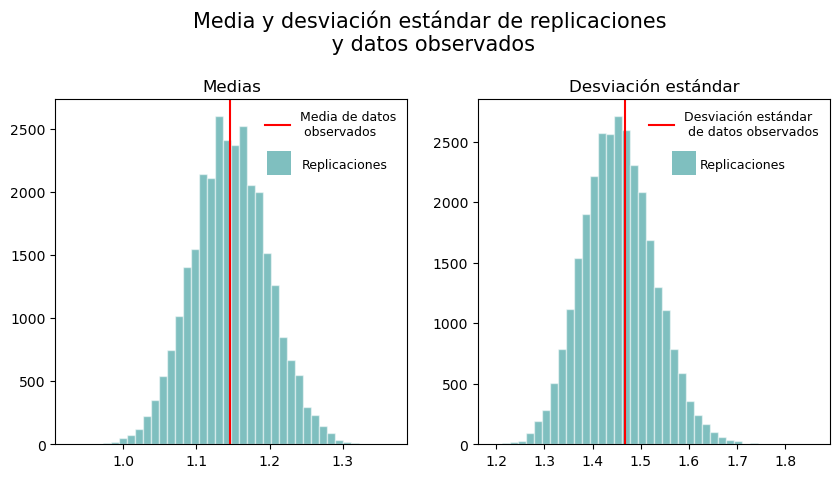

In [22]:
grafica_media_std_replicaciones(estadisticas_replicaciones_visitantes, df_, "visitantes")
plt.savefig(os.path.join(ROOT, "resultados","posteriores",
                         "Media y desviacion histograma: VISITANTES"))

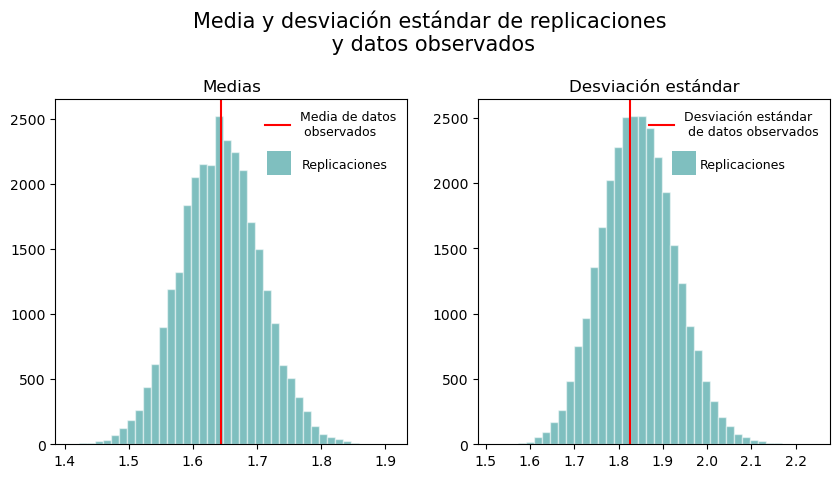

In [23]:
grafica_media_std_replicaciones(estadisticas_replicaciones_locales, df_, "local")
plt.savefig(os.path.join(ROOT, "resultados","posteriores",
                         "Media y desviacion histograma: LOCALES"))

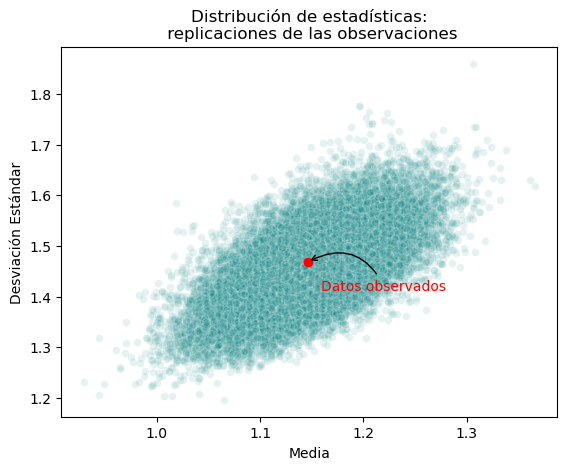

In [24]:
grafica_scatter_estadisticas("visitantes",estadisticas_replicaciones_visitantes, df_)
plt.savefig(os.path.join(ROOT, "resultados","posteriores",
                         "scatter_observados_replicaciones: VISITANTES"))

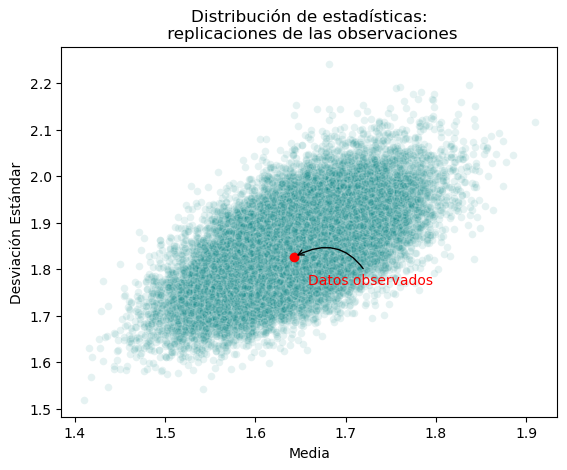

In [26]:
grafica_scatter_estadisticas("local",estadisticas_replicaciones_locales, df_)
plt.savefig(os.path.join(ROOT, "resultados","posteriores",
                         "scatter_observados_replicaciones: LOCALES"))